In [ ]:
import pandas as pd
import numpy as np
import re
import string
from datetime import datetime

import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import plotly.express as px
import plotly.graph_objects as go

In [ ]:
df = pd.read_csv('merge_unique.csv').drop(columns=['Unnamed: 0','index'])
df = df.astype({'tweet_id':'str', 'author_id':'str', 'place_id':'str'})
df.created_datetime = pd.to_datetime(df.created_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316749 entries, 0 to 316748
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   tweet_id          316749 non-null  object        
 1   created_datetime  316749 non-null  datetime64[ns]
 2   content           316749 non-null  object        
 3   author_id         316749 non-null  object        
 4   place_id          316749 non-null  object        
 5   location          308672 non-null  object        
 6   longitude         316749 non-null  float64       
 7   latitude          316749 non-null  float64       
 8   county            316749 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 21.7+ MB


# Temporal Analysis: Frequency of Tweets Across Years

#### Note: Tweets related to "bears" may not necessarily be about actual bear sightings or encounters. Therefore, the distribution presented here may not be representative of the actual frequency of such scenarios. We have provided this visualization for basic understanding purposes only.

In [ ]:
min(df.created_datetime), max(df.created_datetime)

(Timestamp('2010-03-09 00:00:00'), Timestamp('2022-12-31 00:00:00'))

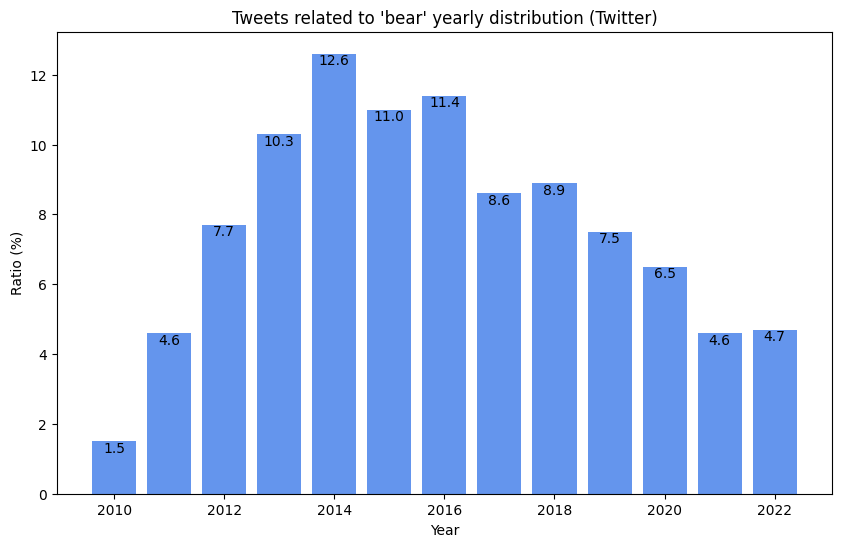

In [44]:
date_tt = pd.to_datetime(list(df.created_datetime))
ratio_tt = [[year, round(num/len(date_tt)*100, 1)] for year, num in Counter(date_tt.year).items()]
ratio_tt_df = pd.DataFrame(ratio_tt, columns=['year', 'ratio(%)'])

# plt
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(ratio_tt_df['year'], ratio_tt_df['ratio(%)'], color='#6495ed')
ax.set_xlabel('Year')
ax.set_ylabel('Ratio (%)')
ax.set_title("Tweets related to 'bear' yearly distribution (Twitter)")
for y, r in zip(ratio_tt_df['year'], ratio_tt_df['ratio(%)']):
    ax.text(y, r, str(r), ha='center', va='top')

plt.show()

# ploty
# fig = px.bar(ratio_tt_df, 
#              x="year", 
#              y="ratio(%)",
#              text='ratio(%)',
#              title="Tweets related to 'bear' yearly distribution (Twitter)")
# fig.show()
# fig.write_html("twitter_yearly_ratio.html")

# Geospatial Analysis: Distribution of Tweets at County-level

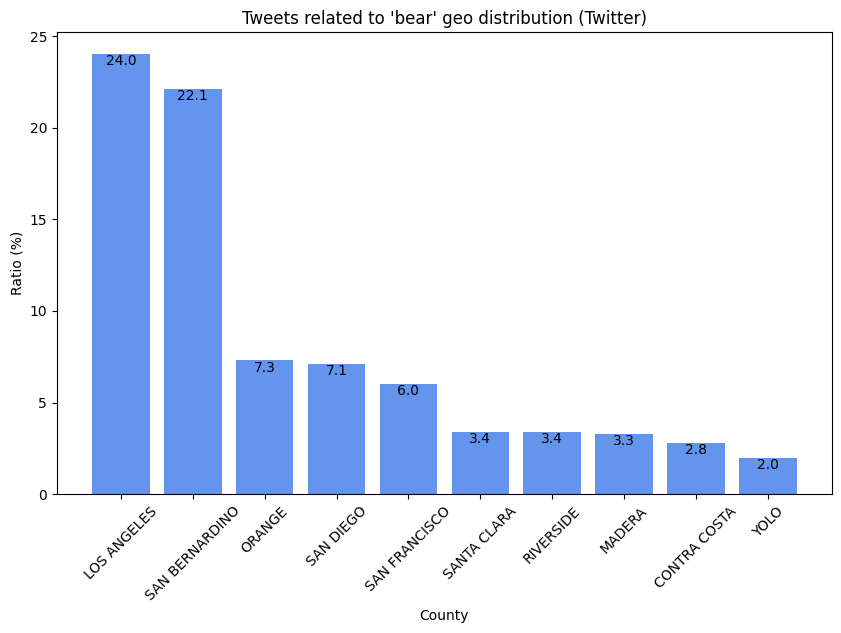

In [45]:
county_tt_count = sorted(Counter(df.county).items(), key=lambda x:-x[1])
geo_tt = [[county, round(num/len(df)*100,1)] for county, num in county_tt_count[:10]]
geo_tt_df = pd.DataFrame(geo_tt, columns=['county', 'ratio(%)'])

# plt
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(geo_tt_df['county'], geo_tt_df['ratio(%)'], color='#6495ed')
ax.set_xlabel('County')
ax.set_xticks(geo_tt_df['county'])
ax.set_xticklabels(geo_tt_df['county'], rotation=45)
ax.set_ylabel('Ratio (%)')
ax.set_title("Tweets related to 'bear' geo distribution (Twitter)")
for y, r in zip(geo_tt_df['county'], geo_tt_df['ratio(%)']):
    ax.text(y, r, str(r), ha='center', va='top')

plt.show()

# ploty
# fig = px.bar(geo_tt_df, 
#              x="county", 
#              y="ratio(%)",
#              text='ratio(%)',
#              title="Tweets related to 'bear' geo distribution (Twitter)")
# fig.show()
# fig.write_html("twitter_geo_ratio.html")

# Textual Analysis: Word Cloud of Most Frequent Words in Tweets

In [ ]:
def clear_text(df):
    contents = ''.join(df.content.values)
    contents = [c for c in contents if c not in string.punctuation]
    contents = ''.join(contents).lower().replace("’","'").replace('”', "'")
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF" # chinese char
        "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r' ',contents)

In [ ]:
def stemmer(contents):
    words = contents.split()
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]

    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(w) for w in words]
    return stemmed

In [ ]:
contents = clear_text(df)
stemmed = stemmer(contents)
counter = Counter(stemmed)
wtuples = counter.most_common(100)
wdict = dict(wtuples)

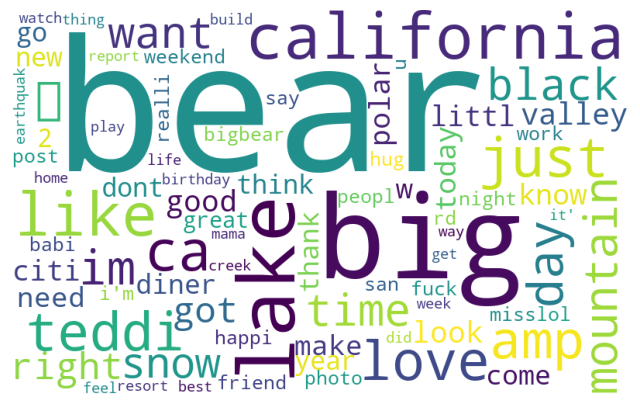

In [ ]:
wordcloud = WordCloud(background_color='white', width=800, height=500, max_words=80)
wordcloud.fit_words(wdict)

fig = plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Reference: Time & geo distributions of iNaturalist data

#### Note: The iNaturalist dataset contains 5545 records of observations or encounters of "American Black Bear" within California, reported by observers between 1988 and 2022. To extract bear-encountering information from bear-related tweets, we use the distribution of this dataset as a reference and visualize it.


#### We will visualize the yearly and monthly patterns of the tweets, as well as their geo distribution at the county level. Although most tweets have a "place guess" feature, they are not standardized and are difficult to compare. Therefore, we will assign a county label to each tweet based on the coordinate features provided by iNaturalist.

In [ ]:
ina = pd.read_csv('iNaturalist_blackbears_CA.csv')
ina.head(3).T

,0,1,2
id,1006,12388,13610
observed_on_string,2006-06-27 18:38:17,2007-09-07,2009-06-14
observed_on,2006-06-27,2007-09-07,2009-06-14
time_observed_at,2006-06-28 01:38:17 UTC,NaN,NaN
time_zone,Pacific Time (US & Canada),Pacific Time (US & Canada),Pacific Time (US & Canada)
user_id,1,710,933
user_login,kueda,johngcramer,chriswbrown
user_name,Ken-ichi Ueda,John Cramer III,Chris Brown
created_at,2008-12-16 07:08:31 UTC,2011-03-07 04:37:36 UTC,2011-04-02 04:50:53 UTC
updated_at,2021-01-26 21:44:34 UTC,2021-08-17 23:13:26 UTC,2021-08-18 21:21:48 UTC


## Yearly and monthly patterns of iNaturalist data

In [ ]:
date = pd.to_datetime([date[:7] for date in ina.observed_on])
min(date), max(date)

(Timestamp('1988-06-01 00:00:00'), Timestamp('2022-11-01 00:00:00'))

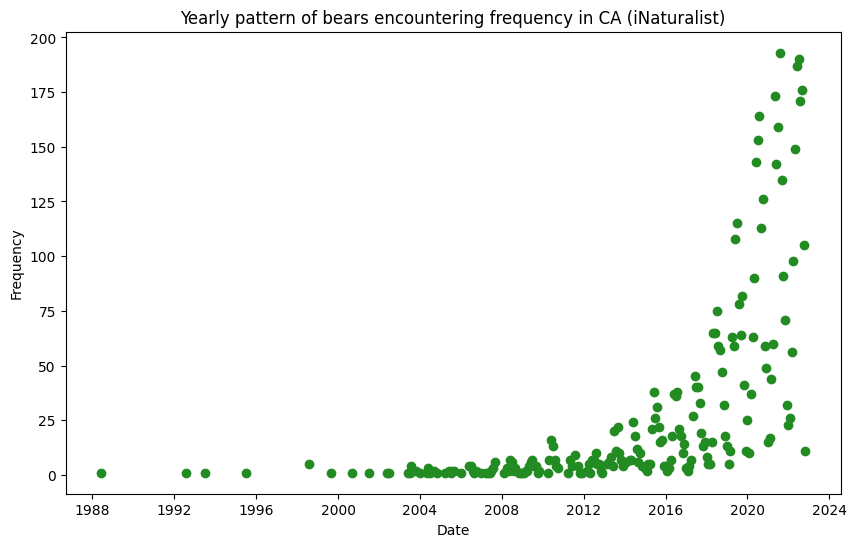

In [50]:
date_count = Counter(date)
date_df = pd.DataFrame(date_count.items(), columns=['date', 'frequency'])

# plt
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(date_df['date'], date_df['frequency'], color='#228B22')
ax.set_xlabel('Date')
ax.set_ylabel('Frequency')
ax.set_title("Yearly pattern of bears encountering frequency in CA (iNaturalist)")

plt.show()

# ploty
# fig = px.bar(date_df, 
#                  x="date", 
#                  y="frequency",
#                  title="Yearly pattern of bears encountering frequency in CA (iNaturalist)")
# fig.show()

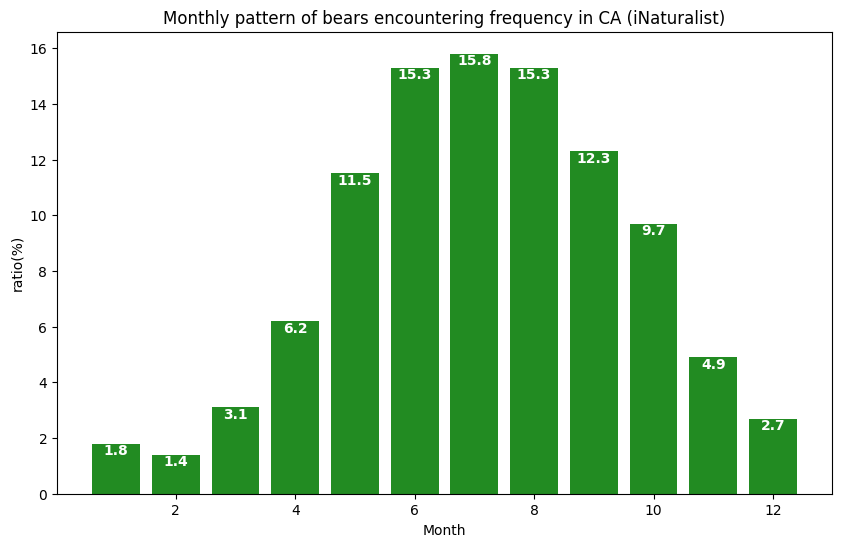

In [58]:
ratio = [[month, round(num/len(date)*100,1)] for month, num in Counter(date.month).items()]
ratio_df = pd.DataFrame(ratio, columns=['month', 'ratio(%)'])

# plt
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(ratio_df['month'], ratio_df['ratio(%)'], color='#228B22')
ax.set_xlabel('Month')
ax.set_ylabel('ratio(%)')
ax.set_title("Monthly pattern of bears encountering frequency in CA (iNaturalist)")
for y, r in zip(ratio_df['month'], ratio_df['ratio(%)']):
    ax.text(y, r, str(r), ha='center', va='top', color='white', fontweight='bold')

plt.show()

# ploty
# fig = px.bar(ratio_df, 
#              x="month", 
#              y="ratio(%)",
#              text='ratio(%)',
#              title="Monthly pattern of bears encountering frequency in CA (iNaturalist)")
# fig.show()
# fig.write_html("inaturalist_monthly_ratio.html")

## County-level distribution of iNaturalist data

In [ ]:
coor = ina[['longitude', 'latitude']]
coor.longitude.astype('float')
coor.latitude.astype('float')
coor = coor.values.tolist()
results = sorted(coor, key=lambda x:x[0])

In [ ]:
# Assign a unified county label to each record based on the coordinates, 
# and then collect them into a list.
as_county = []
grid_df = pd.read_csv('grid_out.csv').sort_values(by=['xmin'])

for i in range(len(results)):
    long, lat = results[i][0], results[i][1]
    loc = ''
    for j in range(len(grid_df)):
        grid_record = grid_df.iloc[j]
        if long <= grid_record.xmax and long >= grid_record.xmin:
            if lat <= grid_record.ymax and lat >= grid_record.ymin:
                loc = grid_record.county
                break
    as_county.append(loc)
len(as_county)

5545

In [ ]:
county_count = sorted(Counter(as_county).items(), key=lambda x:-x[1])
county_count[:10]

[('HUMBOLDT', 1228),
 ('TULARE', 461),
 ('LOS ANGELES', 406),
 ('MARIPOSA', 345),
 ('EL DORADO', 298),
 ('TUOLUMNE', 272),
 ('PLACER', 220),
 ('VENTURA', 169),
 ('SAN BERNARDINO', 166),
 ('FRESNO', 164)]

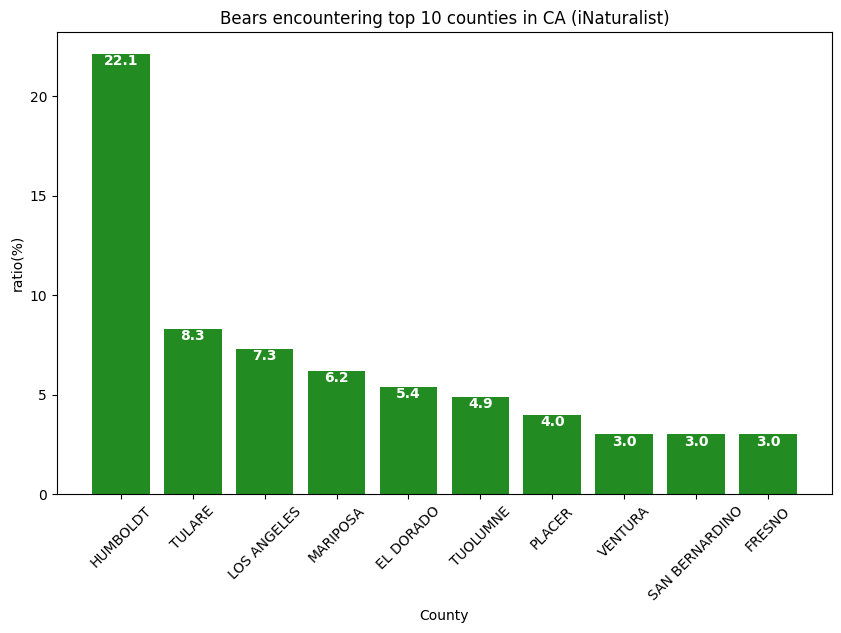

In [57]:
geo = [[county, round(num/len(as_county)*100,1)] for county, num in county_count[:10]]
geo_df = pd.DataFrame(geo, columns=['county', 'ratio(%)'])

# plt
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(geo_df['county'], geo_df['ratio(%)'], color='#228B22')
ax.set_xlabel('County')
ax.set_xticks(geo_df['county'])
ax.set_xticklabels(geo_df['county'], rotation=45)
ax.set_ylabel('ratio(%)')
ax.set_title("Bears encountering top 10 counties in CA (iNaturalist)")
for y, r in zip(geo_df['county'], geo_df['ratio(%)']):
    ax.text(y, r, str(r), ha='center', va='top', color='white', fontweight='bold')

plt.show()

# ploty
# fig = px.bar(geo_df, 
#              x="county", 
#              y="ratio(%)",
#              text='ratio(%)',
#              title="Bears encountering top 10 counties in CA (iNaturalist)")
# fig.show()
# fig.write_html("inaturalist_geo_ratio.html")